# Pix2Pix

A continuación se presenta una implementación de un modelo pix2pix usando tensorflow y keras.
Pix2pix es una arquitectura llamada Pix2Pix, y que te servirá para resolver múltiples problemas de traducción de imágenes. Todo lo que se tratará esta basado en el paper [Image-to-Image Translation with Conditional Adversarial Networks](https://arxiv.org/pdf/1611.07004.pdf)


El problema a resolver es intentar generar imagenes de flores realistas, a partir un conjunto de imagenes de flores previamente procesadas para que se vieran completamente desenfocadas.

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

A continuación definimos Las rutas, primero el path base, donde se encontrara el dataset de imagenes. Dentro de la carpeta input se encontraran las imagenes desenfocadas. En la carpeta output se encuentran las imagenes reales, es deceir las que deberiamos obtener. Checkpoint es la carpeta donde se guardará lo que vayamos procesando, para no perder todo el avance en caso de que algo inesperado suceda.

In [58]:
# Ruta raiz
PATH = 'dataset'
# Ruta datos entrada
INPUT_PATH = PATH + '/input'
# Ruta datos salida
OUTPUT_PATH = PATH + '/output'
# Ruta de los checkpoints
CHECKPOINT_PATH = PATH + '/checkpoints'



Guardaremos en una variable "imgUrls" el listado de los archivos de entrada.

In [ ]:
imgUrls = !ls -1 '{INPUT_PATH}'

Para este ejemplo se usaran 500 imagenes, de las cuales el 80% (400) serán usadas para el entrenamiento y  20% restante serán de prueba. Es importante mezclar las imagenes, de esta forma tendremos una muestra mas homogenea.

In [59]:
n = 500
train_n = round(n * 0.8)

#Listado ramdomizado
randUrls = np.copy(imgUrls)
np.random.seed(23) #seed solo para el tutorial
np.random.shuffle(randUrls)

#Particion conjunto de entrenamiento y de prueba
trUrls = randUrls[:train_n]
tsUrls = randUrls[train_n: n]


## Procesamiento de las imagenes

Basados en el paper implementaremos una función llamada "Random Jitter". Esta función agrega variabilidad dentro del conjunto de entrenamiento, haciendo redimensionamiento de las imagenes para luego recortarlas e incluso dandolas vueltas.

Finalmente las imagenes se normalizan, para dejarlas en el dominio de -1 a 1.

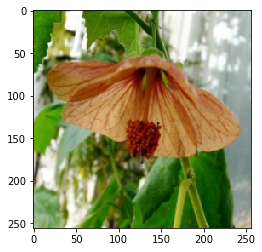

In [61]:
IMG_WIDTH  = 256
IMG_HEIGHT = 256

def resize(inputImg, outputImg, width, height):
  inputImg = tf.image.resize(inputImg, [height, width])
  outputImg = tf.image.resize(outputImg, [height, width])
  return inputImg, outputImg

def normalize(inputImg, outputImg):
  inputImg  = (inputImg/127.5) -1
  outputImg = (outputImg/127.5) -1
  return inputImg, outputImg

# Aumentación de datos: random crop + flip
@tf.function()
def random_jitter(inputImg, outputImg):
  inputImg, outputImg = resize(inputImg, outputImg, 286, 286)
  stakedImg = tf.stack([inputImg, outputImg], axis=0)
  croppedImg = tf.image.random_crop(stakedImg, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  inputImg, outputImg = croppedImg[0], croppedImg[1]

  if tf.random.uniform(()) > 0.5:
    inputImg = tf.image.flip_left_right(inputImg)
    outputImg = tf.image.flip_left_right(outputImg)
  
  return inputImg, outputImg

def load_image(filename, augment = True):
  inputImg   = tf.cast(tf.image.decode_jpeg(tf.io.read_file(INPUT_PATH+ '/' + filename)), tf.float32)[..., :3]
  outputImg  = tf.cast(tf.image.decode_jpeg(tf.io.read_file(OUTPUT_PATH+ '/' + filename)), tf.float32)[..., :3]
  inputImg, outputImg = resize(inputImg, outputImg, IMG_HEIGHT, IMG_WIDTH)
  if augment:
    inputImg, outputImg = random_jitter(inputImg, outputImg)
  inputImg, outputImg = normalize(inputImg, outputImg)
  return inputImg, outputImg


def load_train_image(filename):
  return load_image(filename, True)
def load_test_image(filename):
  return load_image(filename, False)

plt.imshow((load_train_image(randUrls[0])[1]+1)/2)

### Datasets

Crearemos un objeto dataset con el listado de imagenes de entrada y el de prueba, usaremos la funcion map para mapear el listado de los archivos con la funcion load_train_image y la funcion load_test_image. Map permite especificar el número de hilos para a utilizar para procesar las imagenes. Para que tensorflow se encarge de determinar el número de hilos se ocupara la constante AUTOTUNE.

También podemos especificar que se distribuyan los datos en diferentes lotes, siguiendo el paper usararemos lotes o batch de tamaño 1.


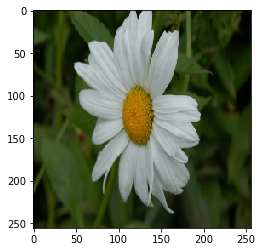

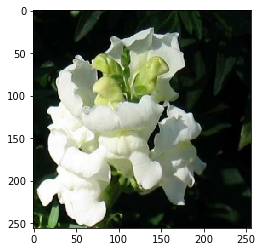

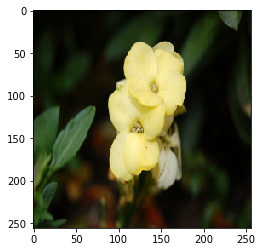

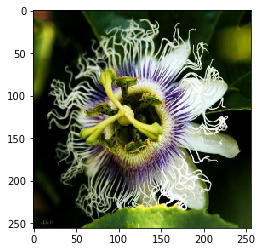

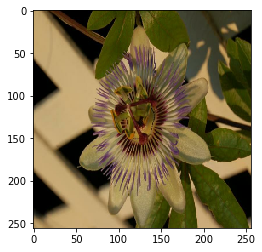

In [62]:
train_dataset = tf.data.Dataset.from_tensor_slices(trUrls)
train_dataset = train_dataset.map(load_train_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(1)

test_dataset = tf.data.Dataset.from_tensor_slices(tsUrls)
test_dataset = test_dataset.map(load_test_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(1)

for inputImg, outputImg in test_dataset.take(5):
  plt.imshow((outputImg[0, ...]+1)/2)
  plt.show()

## Diseño de la arquitectura.

El modelo pix2pix es una red generativa adversaria condicionada, donde el modelo generador viene implementado por una red de tipo U-NETs. Las U-Nets estan compuestas por una parte convulucional encargada de comprimir la información, una parte desconvucional donde se va descomprimiendo y una serie de "skip connections" que conectan cada capa en el mismo nivel. 

![u-nets.png](u-nets.png)

Por otra parte el discriminador es una red de tipo convulucional llamada Patch GAN

Para la construcción de la U-Net, tenemos que crear un enconder compuesto por bloques, cada uno esta formado por una capa convulucional, una de batch normalization y una leaky ReLU. 
    
A estos bloques los llamaremos downSample.
    
Importante: El paper especifica que:
    - Todas la convoluciones son de tamaño 4x4, con un stride de 2.
    - Como excepcion la capa de batch normalization no se aplica a la primera capa del encoder.
    - los pesos son inicializados vienen con un ruido gaussiano de media 0 y una desviación estandar de 0.02.

In [63]:
from tensorflow.keras import *
from tensorflow.keras.layers import *

def downSample(filters, apply_batchnorm=True):
  result = Sequential()
  initializer = tf.random_normal_initializer(0, 0.02)
  # Capa convulucional
  result.add(Conv2D(filters,
                    kernel_size= 4,
                    strides=2,
                    padding='same',
                    kernel_initializer=initializer,
                    use_bias=not apply_batchnorm))
  # Capa de BatchNorm
  if apply_batchnorm:
    result.add(BatchNormalization())
  # Capa de activación
  result.add(LeakyReLU())
  
  return result

downSample(64)

De forma parecida al encoder, el decoder esta compuesto por bloques, cada uno de ellos formado por una capa convulucional inversa, una de batch normalization y una ReLU

Además el paper añade una la capa de dropout, que se encarga de desconectar una serie de conexiones de manera aleatorea y que sirve de elemento regularizador de la red.

In [64]:
def upSample(filters, apply_dropout=False):
  result = Sequential()
  initializer = tf.random_normal_initializer(0, 0.02)
  # Capa convulucional
  result.add(Conv2DTranspose(filters,
                             kernel_size= 4,
                             strides=2,
                             padding='same',
                             kernel_initializer=initializer,
                             use_bias=False))
  # Capa de BatchNorm
  result.add(BatchNormalization())

  # Capa de dropout
  if apply_dropout:
    result.add(Dropout(0.5))
  
  # Capa de activación
  result.add(ReLU())
  return result


upSample(64)

### Función Generadora

En la función generadora declaramos cada uno de los bloques de downSampling y upSampling especificados en el paper.

<img src="layers.png" width="300">

Luego de ejecutar los bloques de downSampling y upSampling, tenemos que generar nuestra imagen final, por lo que tenemos que añadir una ultima capa. Finalmente, hay que agregar las skips connections, para que se comparta información desde el codificador al decodificador.


In [65]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[None, None, 3])

  downStack = [
    downSample(64, apply_batchnorm=False),     #(bs, 128, 128, 64)
    downSample(128),                           #(bs, 64, 64, 128)
    downSample(256),                           #(bs, 32, 32, 256)
    downSample(512),                           #(bs, 16, 16, 512)
    downSample(512),                           #(bs, 8, 8, 512)
    downSample(512),                           #(bs, 4, 4, 512)
    downSample(512),                           #(bs, 2, 2, 512)
    downSample(512)                            #(bs, 1, 1, 512)    
  ]

  upStack = [
    upSample(512, apply_dropout=True),         #(bs, 2, 2, 1024)
    upSample(512, apply_dropout=True),         #(bs, 4, 4, 1024)
    upSample(512, apply_dropout=True),         #(bs, 8, 8, 1024)
    upSample(512),                             #(bs, 16, 16, 1024)
    upSample(256),                             #(bs, 32, 32, 512)
    upSample(128),                             #(bs, 64, 64, 256)
    upSample(64)                               #(bs, 128, 128, 128)
  ]
  initializer = tf.random_normal_initializer(0, 0.02)
  last =  Conv2DTranspose(filters=3,
                          kernel_size=4,
                          strides=2,
                          padding='same',
                          kernel_initializer=initializer,
                          activation='tanh')
  x = inputs
  skipConnections = []
  concat = Concatenate()

  for down in downStack:
    x = down(x)
    skipConnections.append(x)

  skipConnections= reversed(skipConnections[:-1])
  for up, sk in zip(upStack, skipConnections):
    x = up(x)
    x = concat([x, sk])
  last = last(x)
  return Model(inputs=inputs, outputs=last)

generator = Generator()

### Función Discriminadora

La tarea del discriminador es observar el resultado del generador, diferenciando si el resultado es correcto o no, segun lo que entienda por imagen correcta.
En este paper en vez de usar un discriminador tradicional, que solo te lleve a un resultado final (True or false), ocupan un tipo de red denominada patchGan. 

PathGan devuelve una cuadricula donde se van a evaluar distintas porciones de la imagen original.

Se ocupo el discriminador de 70x70, que viene especificado por un bloque de 64, 128, 256 y 512. Finalmente se aplica una convolución que ser unidimensional, seguido la una función sigmoide. la capa de batch normalization no se aplica a el primer bloque. Todas las ReLU son leaky.

La ultima capa tiene un solo filtro de salida, porque necesitamos que solo exista un canal, dado que solo necesitamos saber que tan parecida es la imagen generado con la real.

In [66]:
def Discriminator():
  ini =  Input(shape=[None, None, 3], name='input_img')
  gen =  Input(shape=[None, None, 3], name='gener_img')
  
  con = concatenate([ini, gen])
  initializer = tf.random_normal_initializer(0, 0.02)

  down1 = downSample(64, apply_batchnorm=False)(con)
  down2 = downSample(128)(down1)
  down3 = downSample(256)(down2)
  down4 = downSample(512)(down3)

  last = tf.keras.layers.Conv2D(filters=1,
                                kernel_size=4,
                                strides=1,
                                kernel_initializer=initializer,
                                padding='same')(down4)
  return Model(inputs=[ini, gen], outputs=last)

discriminator = Discriminator()


### Función de coste adversaria

El objeto lost_object nos servirá para evaluar el resultado de las imagenes generadas. BinaryCrossentropy calcula la entropia cruzada de cada uno de los pixeles de las imagenes que vamos obteniendo.

from_logits se encarga de normalizar las imagenes pasandola por una función sigmoide para acotarlas al dominio de 0 y 1.

### Discriminator Loss
definiremos real_loss y generated_loss. El primero lo que esta haciendo es ocupar lost_object para comparar el resultado del discriminador al observar una imagen real con el resultado idóneo. Por otro lado el generated_loss es la comparación del la imagen del generador con el resultado idóneo del discriminador,


Por otro lado tenemos el generated_loss, que busca comprobar el resultado del discriminador al observar la imagen generada, comparando con el resultado idóneo para el discriminador, que en este caso seria una matriz con todos lo valores a cero, es decir, que para el discriminador lo ideal sería encontrar que todo los pixiles que estoy observando son falsos.



In [67]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [68]:
def discriminator_loss(disc_real_output, disc_generated_output):
  # Diferencia entre los true por ser real y el detectado por el discriminador
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
  # Diferencia entre los false por ser generado y el detectado por el discriminador
  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss
  return total_disc_loss
  

### Generator Loss

El generador tiene 2 objetivos, uno que la imagen sea realista pero también debe lograr que el error del discriminador se maximize. Es por esto que se computa el error adversario(gan_loss) y el l1_loss que es la diferencia por pixiles entre la imagen generada y la que queremos obtener.

In [69]:
LAMBDA = 100
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
  total_gen_loss = gan_loss + (LAMBDA*l1_loss)
  return total_gen_loss
  

In [70]:
import os

generator_optimizer     = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

checkpoint_prefix = os.path.join(CHECKPOINT_PATH, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)

### Función generate_images

La función generate_images nos permite pasarle al generador imagenes de nuestro set de pruebas y al mismo tiempo podemos guardar las imagenes predichas, en este caso en la carpeta generated-outpur. Finalmente muestra las imagenes obtenidas.

In [71]:
def generate_images(model, test_input, tar, save_filename=False, display_imgs=True):
  prediction = model(test_input, training=True)

  if save_filename:
    tf.keras.preprocessing.image.save_img(PATH + '/generated-output/' + save_filename + '.jpg', prediction[0, ...])
    plt.figure(figsize=(10,10))
    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    if display_imgs:
      for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0,1] to plot it
        plt.imshow(display_list[i]*0.5 +0.5)
        plt.axis('off')
    plt.show()

### Train_step

El generador va a tomar como entrada input_image, esta imagen va a ser comprimida por el encoder, descomprimida por el decoder y vamos a obtener una imagen de salida (output_image). El discriminador nos entregará el out_gen_discr, en función de lo observado en la imagen generada, lo mismo hará con la imagen real entregando output_trg_discr.

Luego con el out_gen_discr y el output_trg_discr, se calcula el discr_loss y el gen_loss.

Se calculan los gradientes del generador, para optimizar todos los parametros que conforman a mi generador. Seguimos de la misma forma con el discrimandor. Finamente aplicamos los gradientes y optimizamos usando Adam.


In [72]:
@tf.function()
def train_step(input_image, target):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as discr_tape:
    output_image = generator(input_image, training=True)

    output_gen_discr = discriminator([output_image, input_image], training=True)

    output_trg_discr = discriminator([target, input_image], training=True)
    
    discr_loss = discriminator_loss(output_trg_discr, output_gen_discr)
    gen_loss = generator_loss(output_gen_discr, output_image, target)

    generator_grads = gen_tape.gradient(gen_loss, generator.trainable_variables)
    discriminator_grads = discr_tape.gradient(discr_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(generator_grads, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_grads, discriminator.trainable_variables))



### Train
Train se encargará del entrenamiento en general, recibirá las epocas y llamará a train_step cuantas veces sea deseado.
Finalizada cada época mostrará y guardará las imagenes generadas.

In [73]:
from IPython.display import clear_output

def train(dataset, epochs):
  for epoch in range(epochs):
    imgi = 0
    for input_image, target in dataset:
      print('epoch '+ str(epoch)+ '-train: '+str(imgi)+ '/'+ str(len(trUrls)))
      imgi+=1
      train_step(input_image, target)
      clear_output(wait=True)
    imgi = 0  
    for inp, tar in test_dataset.take(5):
      generate_images(generator, inp, tar, str(imgi) + '_'+ str(epoch), display_imgs=True)
      imgi+=1
    # saving (checkpoint) the model every 20 epoch
    if (epoch+1)%25 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

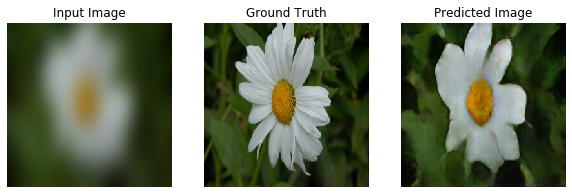

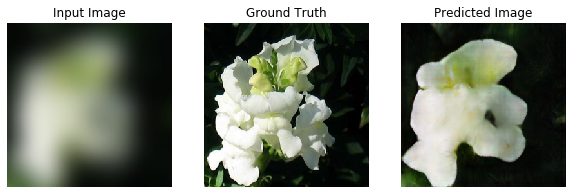

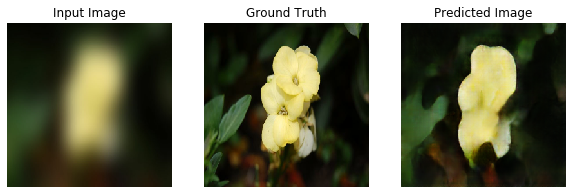

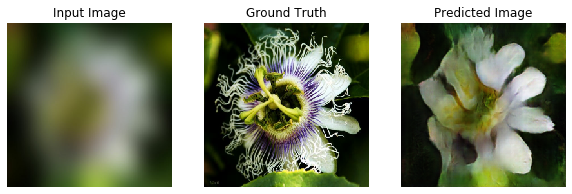

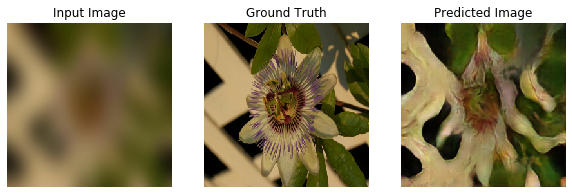

In [74]:
train(train_dataset, 100)